In [1]:
#Importing libraries                                                                                                                                import pandas as pd
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os
import netCDF4
import pandas as pd
import datetime
import scipy
import math
import matplotlib
import matplotlib.image as mpimg
from scipy import interpolate
import matplotlib.dates as mdates
from scipy.stats import *
import locale
import time
locale.getlocale()
# locale.setlocale(locale.LC_TIME,'en_US.)
locale.setlocale(locale.LC_TIME,'en_US.utf8')
locale.setlocale(locale.LC_ALL, 'en_US.utf8')
print(time.strftime("%d-%b-%Y"))


04-Sep-2022


In [2]:
#functions
def Language(g):
    global tunits,labeltM1,labelTS1,tlabel,Name
    if g=='RU':
        tunits='скорость верта м/с'
        labeltM1='WRF'
        labelTS1='наблюдение'  
        tlabel='Время суток'
        Name='NameRU'
        #locale.setlocale(locale.LC_TIME, 'ru_RU.UTF-8')
    elif g=='EN':
        tunits='Wind speed m\s' 
        labeltM1='WRF Data sfc'
        labelTS1='Observation'     
        tlabel='Hour'
        Name='Name'
        locale.setlocale(locale.LC_TIME,'en_US.utf8')
def GeneratingListOfVariables(file_nc):
    nc = netCDF4.Dataset(file_nc,'r+')
    #print(nc.variables.items())
    times = nc.variables['time']
    #print(times)
    jd = netCDF4.num2date(times[:],times.units)
    nc.close
    variables=list(nc.variables.keys())[3::]
    return nc.variables,variables
def Graphercore(i,Variable,vari):
            lat=np.array(Variable['lat'])
            lon=np.array(Variable['lon'])
            Coord2= np.argmin(np.abs(lon - LOND[i]))
            Coord1= np.argmin(np.abs(lat - LATD[i]))
            print(lat[Coord1],lon[Coord2],'Lee coordinates')
            Var=np.array(Variable[vari])
            Var=Variable[vari][:,Coord1,Coord2]
            #date=Variable['time'].units.replace('minutes since ','')
            jd=pd.date_range(date,periods=len(Variable['time']),freq='H',name='Date')
            hs = pd.Series(Var,name=vari,index=jd) 
            return hs

In [3]:
LANG='RU'
Language(LANG)

INPUT DATA

In [15]:
date='2018-07-12 19:00';Date1='2018-07-13';Date2='2018-07-15';Date='20180713';Date3='2018-07-15 22:00'
ymin=0
ymax=15
locale.setlocale(locale.LC_TIME, 'ru_RU.UTF-8')
Stations=[21206600,21206920,21206960,21185090,21195170,23035030,26145090]#the ones used to validate 


MAPPING STATIONS

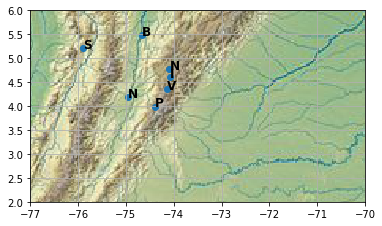

In [23]:
LATD=[]
LOND=[]
ALTD=[]
NAME=[]
Stationss=Stations
for i in range(len(Stationss)):
    i
    COD=Stationss[i]
    St=pd.read_csv('/media/usuario/7fad240a-7ab6-43a9-a6ff-db074983559c/home/smeagle/Escritorio/All/Tesis/DATA/DataProcessing/Stations.csv')#Opening file with coordinates of Stations
    NAME.append(str.title(St[St['Station']==COD]['Name'].values[0]))
    LATD.append(round(St.latitud[St['Station']==COD].values[0],2))
    LOND.append(round(-St[St['Station']==COD]['longitud'].values[0],2))
    ALTD.append(St[St['Station']==COD]['altitud'].values[0])
ST=pd.DataFrame({'Name':NAME,'Longitude':LOND,'Latitude':LATD,'Altitude':ALTD},index=Stationss)
# F = [chr(ord('a') + x).upper() for x in ST.index]
ST.to_csv('StationsERAValidation.csv')
fig,ax=plt.subplots()
#ax.imshow(mpimg.imread('/media/usuario/7fad240a-7ab6-43a9-a6ff-db074983559c/home/smeagle/Escritorio/All/Tesis/DATA/ERA5vsDATA/Colombia_Topography_2.png'),extent=(-80,-68,2,14))
IMTIF='Colombia_relief_location_map_modified'
ax.imshow(mpimg.imread('/media/usuario/7fad240a-7ab6-43a9-a6ff-db074983559c/home/smeagle/Escritorio/All/DATA/WRFValidation/Colombia_relief_location_map.jpg'),extent=(-85.12,-66.44,-4.6,16.6))
plt.ylim([2,6])
plt.xlim([-77,-70])
plt.grid()
#LONN=[str(-x)+' W' for x in LON]
#ax.set_xticklabels(LONN)
for i, txt in enumerate(NAME):
    ax.annotate(str(txt)[0], (LOND[i], LATD[i]),color='black',weight='bold',fontsize=12)
ax.scatter(LOND,LATD,label='Data Stations')
# ax.scatter(LOND[0],LATD[0],label='Data Stations')#Just for onem station
# ax.scatter(LON,LAT,label='ERA 5')
# ax=fig.gca()
# plt.legend()
plt.show()


STATIONS AND COORDINATES

In [24]:
# ST['NameRU']=['Асиенда Пахоналес','Натайма','Асиенда Манила','Пакило','База Паланкеро',]
ST

,Name,Longitude,Latitude,Altitude
21206600,Nueva Generacion,-74.09,4.78,2590
21206920,Villa Teresa,-74.15,4.35,3624
21206960,Ideam Bogota,-74.07,4.60,2646
21185090,Nataima,-74.96,4.19,393
21195170,Paquilo,-74.40,3.99,2957
23035030,Base Palanquero,-74.66,5.49,170
26145090,Santa Emilia,-75.90,5.21,1748


FUNCTION FOR:
    
    1. PLOTTING SIMULATED AND REAL DATA
    2. MAKING SCATTERPLOTTS
    3. FINDING MAE, MBE, CORRELATIONS, STANDARD DEVATIONS AND P-VALUES

In [26]:
def Plotting(i):
    Language(LANG)
    ###############################
    #Uploading station data
    ###############################
    Path='/media/usuario/7fad240a-7ab6-43a9-a6ff-db074983559c/home/smeagle/Escritorio/All/DATA/DATAfromIdeam/RADICADO_20229050002332/'
    Variable='VV_AUT_10@'
#     Variable='VVAG_CON@'
    StationT=str(Stations[i])
    Bs=pd.read_csv(Path+Variable+StationT+'.data',delimiter='|',parse_dates=True,header=0,names=['time','Station Data'],index_col='time')
    ###############################
    #Loading WRF data
    ###############################
    path='/media/usuario/7fad240a-7ab6-43a9-a6ff-db074983559c/home/smeagle/Escritorio/All/Tesis/WRF/'
    path3='/media/usuario/7fad240a-7ab6-43a9-a6ff-db074983559c/home/smeagle/Escritorio/All/DATA/WRFValidation/WindSpeed/'
    path3='/home/usuario/Desktop/imagesTobeerased/'
    Fil = ['/U10M.nc','/V10M.nc' ];vari=['u10m','v10m']
    fn=[ path+Date+i for i in Fil]
    ###############################
    UU,u=GeneratingListOfVariables(fn[0])
    VV,v=GeneratingListOfVariables(fn[1])                                        
    U=Graphercore(i,UU,vari[0])
    V=Graphercore(i,VV,vari[1])
    ###############################
    #Calculating magnitude of wind
    ###############################                                     
    B=np.sqrt(U**2+V**2)+6
    ###############################
    #Plots
    ################################
    fig, ax = plt.subplots()
    ax.set_ylim([ymin, ymax])
    B.plot(ylabel=tunits,ax=ax,label='WRF Data sfc')
    Bs[Bs.index.minute == 0][Date1:Date3].plot(ax=ax,xlim=[Date1,Date3],style='o',markersize=4)                      
    ax.set_xlabel(tlabel)
    ax.legend(loc='best',bbox_to_anchor=(1., 1.12))
#     ax.get_legend().remove()
    string=Date+'Vel'+ST.loc[Stations[i]]['Name']+'.png'
    plt.savefig(path3+string.replace(" ", ""), bbox_inches = "tight")
    ################################
    #Correlations
    ################################
    B.corr(Bs[Date1:Date2]['Station Data'])
    ST.loc[int(StationT),[r'$\rho$']]=round(B.corr(Bs[Date1:Date2]['Station Data']),2)
    ################################
    #Scatterplots
    ################################
    #print(ST.loc[Stations[i]])
    x=B[Date1:Date3]
    y=Bs[Bs.index.minute == 0][Date1:Date3].dropna()
    hh=x[x.index.isin(y.index)==True]
    fig2, ax2 = plt.subplots()
    ax2.set_xlabel(tunits);ax2.set_ylabel(tunits)
    ax2.scatter(hh,y,label=ST.loc[Stations[i]]['Name'])
    plt.legend()
    string=Date+'Vel'+'Scatter'+ST.loc[Stations[i]]['Name']+'.png'
    plt.savefig(path3+string.replace(" ", ""),bbox_inches='tight')
    plt.show()
    #################################
    # Mean Absolute Error MAE
    # Mean Bias     Error MBE
    #################################
    MAE=round(np.nansum(abs(hh.to_numpy()-y.to_numpy().T))/len(y),2)
    MBE=round(np.nansum(hh.to_numpy()-y.to_numpy().T)/len(y),2)
    ST.loc[int(StationT),['MAE']]=MAE
    ST.loc[int(StationT),['MBE']]=MBE
    rho=B.corr(Bs[Date1:Date2]['Station Data'])
    n=len(Bs[Date1:Date3])-2
    tSt=rho*math.sqrt(n-2)/math.sqrt(1-rho**2)
    pval = t.sf(np.abs(tSt), n)*2
    ST.loc[int(StationT),[r'$p_{val}$']]=str(pval)[0:4]+str(pval)[-4::]
    

4.7751 -74.10808695652175 Lee coordinates
4.7751 -74.10808695652175 Lee coordinates


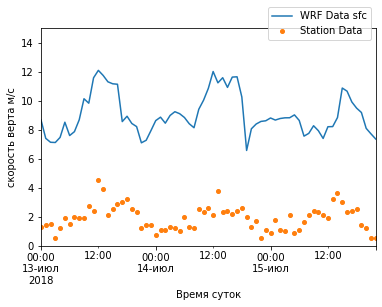

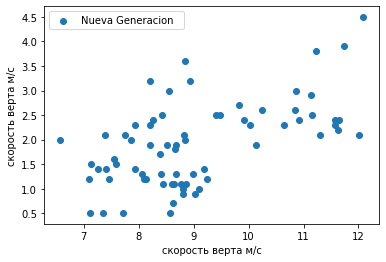

4.3701 -74.15323076923077 Lee coordinates
4.3701 -74.15323076923077 Lee coordinates


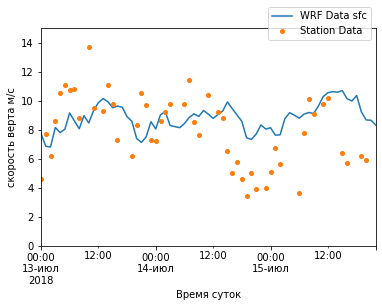

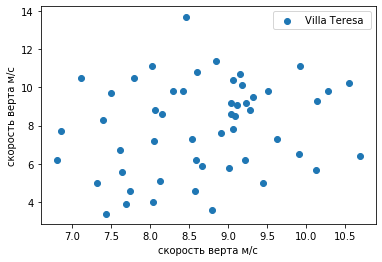

4.5951 -74.06294314381272 Lee coordinates
4.5951 -74.06294314381272 Lee coordinates


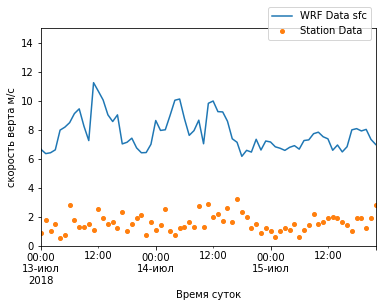

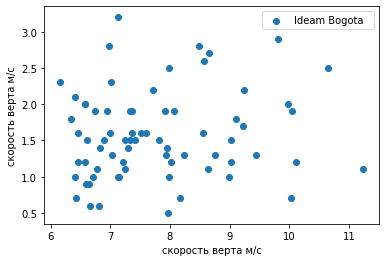

4.19 -74.96581939799331 Lee coordinates
4.19 -74.96581939799331 Lee coordinates


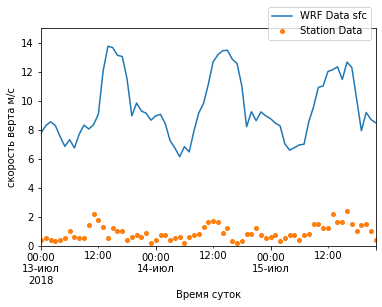

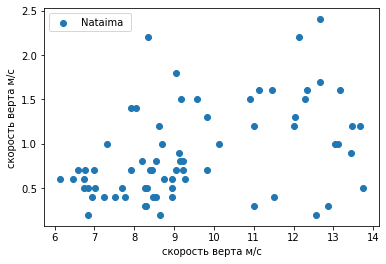

4.0099 -74.37894983277593 Lee coordinates
4.0099 -74.37894983277593 Lee coordinates


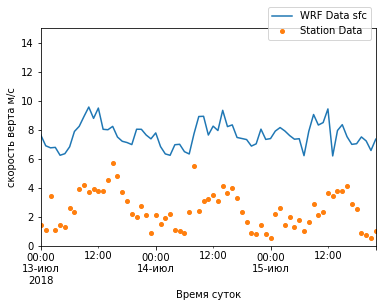

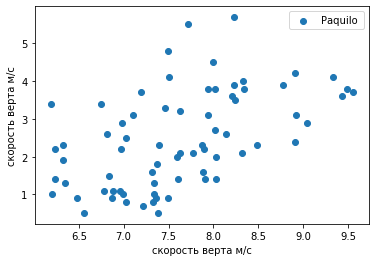

5.4945 -74.6498127090301 Lee coordinates
5.4945 -74.6498127090301 Lee coordinates


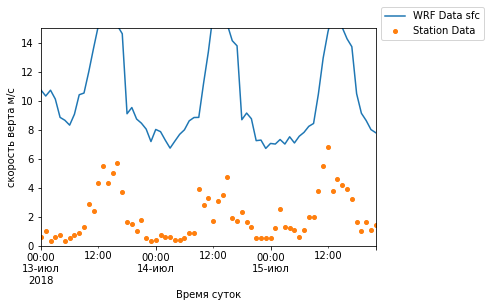

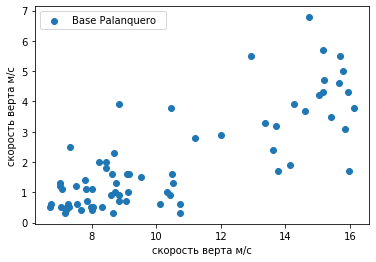

5.2248 -75.91383946488294 Lee coordinates
5.2248 -75.91383946488294 Lee coordinates


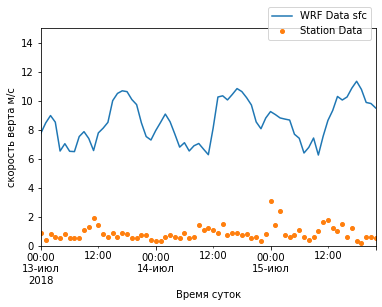

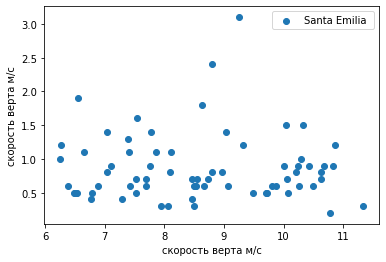

In [27]:
for i in range(len(Stations)):
    Plotting(i)

In [28]:
ST

,Name,Longitude,Latitude,Altitude,$\rho$,MAE,MBE,$p_{val}$
21206600,Nueva Generacion,-74.09,4.78,2590,0.57,7.15,7.15,1.50e-37
21206920,Villa Teresa,-74.15,4.35,3624,0.21,2.00,0.74,7.34e-05
21206960,Ideam Bogota,-74.07,4.60,2646,0.13,6.20,6.20,0.006393
21185090,Nataima,-74.96,4.19,393,0.44,8.61,8.61,9.03e-21
21195170,Paquilo,-74.40,3.99,2957,0.52,5.15,5.15,8.46e-30
23035030,Base Palanquero,-74.66,5.49,170,0.79,8.43,8.43,1.73e-91
26145090,Santa Emilia,-75.90,5.21,1748,-0.00,7.71,7.71,0.979929
